In [68]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

NAME RANJAN KUMAR
PRN 230940141021
HPCAP

# Introduction to AI and OpenVino
## Assignment 05 - Santander XGBOOST


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
###------------------
### Import statements
###------------------

import sys
import os
from time import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


In [71]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join( '../input')

# set location of inputs for this module
moduleDir = 'santander'

# set location of output files
outDir = os.path.join('../output')

# define and set random state
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.1
N_SAMPLES = 1000
ALPHA = 0.001

# parameters for Matplotlib
params = {'legend.fontsize': 'small',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE = 0.20

<Figure size 1500x500 with 0 Axes>

## Helper Function

In [72]:
###-----------------------
### plot decision boundary
###-----------------------

def fn_plot_decision_boundary(pred_func, X, y, ax = None):
    '''
        Attrib:
           pred_func : function based on predict method of
                    the classifier
           X : feature matrix
           y : targets
       Return:
           None
    '''
    if ax is None:
        ax = plt.gca()

    # Set min and max values and give it some padding
    xMin, xMax = X[:, 0].min() - .05, X[:, 0].max() + .05
    yMin, yMax = X[:, 1].min() - .05, X[:, 1].max() + .05

    # grid size for mesh grid
    h = 0.05

    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))

    # Predict the function value for the whole grid
    Z = pred_func.predict(np.c_[xx.ravel(), yy.ravel()])

    # Make its shape same as that of xx
    Z = Z.reshape(xx.shape)

    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP, alpha = 0.6)

    # plot the points as well
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=CMAP, edgecolors='black')

In [73]:
###---------------------------
### plot svc Decision Function
###---------------------------
def fn_plot_svc_decision_function(clf):

    """Plot the decision function for a 2D SVC"""

    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)

    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)

    Y, X = np.meshgrid(y, x)

    P = np.zeros_like(X)

    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #print (clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0])
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1, -1))[0]
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

In [74]:
###---------------------------------------
### Function to plot Loss Curve tensorflow
###---------------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]

    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')

    plt.tight_layout()

## Question:
* What did you do too address missing values?
* What data wrangling do you recommend?

In [75]:
train_df = pd.read_csv(os.path.join(inpDir, moduleDir, 'train.csv'))
test_df = pd.read_csv(os.path.join(inpDir, moduleDir, 'test.csv'))
display(train_df.head(10))
display(test_df.head(10))

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,13,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,14,2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,18,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,20,2,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101962.020000,0
9,23,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,356463.060000,0


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,73649.73
5,11,2,43,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,53250.87
6,12,2,39,495.0,2334.42,4815.42,0.0,0.0,0.0,0.0,...,0.0,7077.51,0.0,7599.0,7338.27,0.0,0.0,0.0,0.0,58316.64
7,15,2,29,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,46898.49
8,16,2,53,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,110356.98
9,17,2,37,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,41366.49


In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


train_df.describe().T is returning a summary of each feature (column) in the dataframe, where T is a reference to the 'transpose' operation

In [77]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,76020.0,75964.050723,43781.947379,1.00,38104.7500,76043.00,113748.7500,151838.00
var3,76020.0,-1523.199277,39033.462364,-999999.00,2.0000,2.00,2.0000,238.00
var15,76020.0,33.212865,12.956486,5.00,23.0000,28.00,40.0000,105.00
imp_ent_var16_ult1,76020.0,86.208265,1614.757313,0.00,0.0000,0.00,0.0000,210000.00
imp_op_var39_comer_ult1,76020.0,72.363067,339.315831,0.00,0.0000,0.00,0.0000,12888.03
...,...,...,...,...,...,...,...,...
saldo_medio_var44_hace3,76020.0,1.858575,147.786584,0.00,0.0000,0.00,0.0000,24650.01
saldo_medio_var44_ult1,76020.0,76.026165,4040.337842,0.00,0.0000,0.00,0.0000,681462.90
saldo_medio_var44_ult3,76020.0,56.614351,2852.579397,0.00,0.0000,0.00,0.0000,397884.30
var38,76020.0,117235.809430,182664.598503,5163.75,67870.6125,106409.16,118756.2525,22034738.76


train_df['TARGET'].value_counts() is counting the number of occurrences of each unique value in the 'TARGET' column of the dataframe train_df.

In [78]:
train_df['TARGET'].value_counts()


0    73012
1     3008
Name: TARGET, dtype: int64

class_names = train_df['TARGET'].unique() is creating a numpy array containing all the unique values in the 'TARGET' column of the dataframe train_df.

## distribution of the class in skewed

In [79]:
class_names = train_df['TARGET'].unique()
class_names

array([0, 1])

it is used to visualize the distribution of the target variable (TARGET) in the dataframe train_df.

Here is a step-by-step explanation of what this command does:

The function plt.subplots() is used to create a new figure and a set of subplots within this figure. In this case, it creates a single subplot with the specified size.

The variable explode is set to (0, 0.2), which means that the first class (in this case, the first class is 0, since class names start from 0) will not be offset from the center of the pie chart, while the other classes will be offset by 0.2.

The ax.pie() function is used to create a pie chart within the specified subplot. It takes several arguments, such as the data to be plotted (here, it is the value counts of the TARGET column), the explode parameter, the labels for the classes, and several formatting parameters.

The ax.axis('equal') line ensures that the pie chart is drawn as a circle.


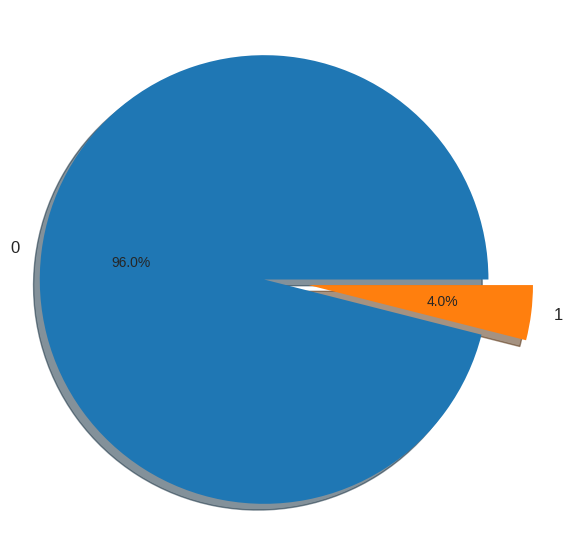

In [80]:
fig, ax = plt.subplots(figsize = (7,7))
explode = (0, 0.2)
ax.pie(train_df['TARGET'].value_counts(), explode=explode, labels=class_names, autopct='%1.1f%%', shadow=True, startangle=0)
ax.axis('equal')
plt.show()

In [81]:

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt

## Features Engineering

This code creates a histogram for a feature named 'var15' in both the train_df and test_df dataframes.

Here is a step-by-step explanation of what this command does:

The function plt.subplots() is used to create a new figure and a set of subplots within this figure. In this case, it creates a figure with a single row and two columns of subplots.

The variable ax is used to access each of the subplots within the figure. The histogram for the 'var15' feature in the train_df dataframe is created using the command train_df['var15'].hist(bins=25, ax=ax). Here, the histogram is divided into 25 bins, and the resulting histogram is drawn in the first subplot.

The variable ax is then used to access the second subplot, which is used to create the histogram for the 'var15' feature in the test_df dataframe. The histogram is created using the command test_df['var15'].hist(bins=25, ax=ax).

The ax.set_title() function is used to add a title to each subplot, identifying which dataset the histogram corresponds to (either 'train' or 'test').

Finally, the plt.show() function is used to display the figure with the histograms.





Text(0.5, 1.0, 'test')

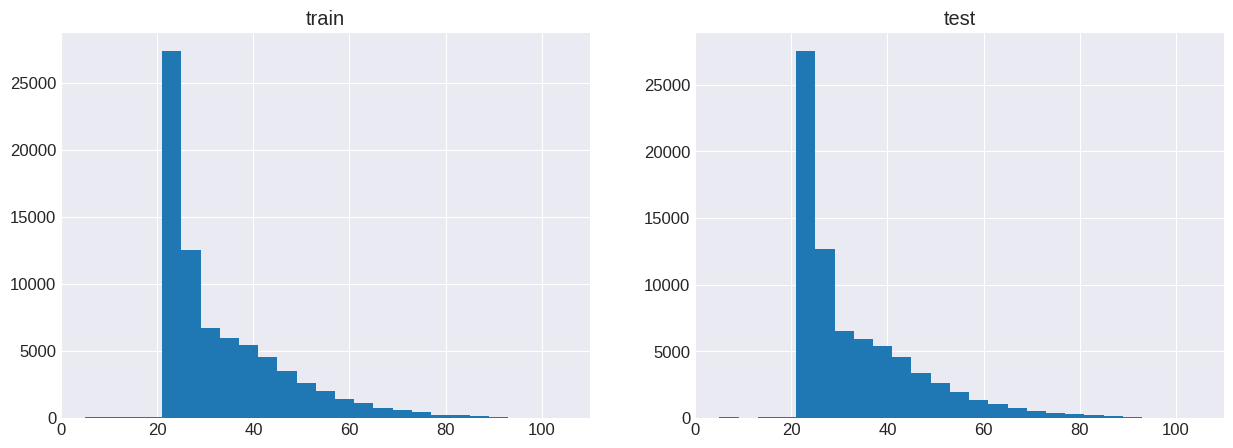

In [82]:
# Var15 is AGE
fig, axes = plt.subplots(1, 2)
ax = axes[0]
train_df['var15'].hist(bins=25, ax=ax)
ax.set_title('train')
ax = axes[1]
test_df['var15'].hist(bins=25, ax=ax)
ax.set_title('test')

print(len(train_df['TARGET'][train_df.var15 < 23])) is used to find the number of instances where 'var15' is less than 23 in the train_df dataset.

Similarly, print(sum(train_df['TARGET'][train_df.var15 < 23])) is used to find the sum of the 'TARGET' values for these instances.





In [83]:
print(len(train_df['TARGET'][train_df.var15 < 23]))
print(sum(train_df['TARGET'][train_df.var15 < 23]))

1212
0


train_df['n0'] = (train_df==0).sum(axis=1): For each row in the train_df dataframe, this line of code counts the number of columns where the value is 0 and assigns this count to a new column 'n0' in the train_df dataframe.

test_df['n0'] = (test_df==0).sum(axis=1): The same process is applied to the test_df dataframe. For each row in the test_df dataframe, this line of code counts the number of columns where the value is 0 and assigns this count to a new column 'n0' in the test_df dataframe.

print(train_df.shape): Finally, this line of code prints the shape of the train_df dataframe, which includes the number of rows and columns in the dataframe. 





In [84]:
train_df['n0'] = (train_df==0).sum(axis=1)
test_df['n0'] = (test_df==0).sum(axis=1)
print(train_df.shape)

(76020, 372)


train_df[col].std() == 0: For each column in the train_df dataframe, this line of code checks if the standard deviation of the values in that column is 0. The standard deviation is a measure of the dispersion or spread of a set of values. If the standard deviation is 0, it means that all the values in that column are the same.

drop_cols.append(col): If the standard deviation of the values in a column is 0, this line of code adds the column name to the drop_cols list.

train_df.drop(drop_cols,axis=1, inplace=True): This line of code drops the columns listed in the drop_cols list from the train_df dataframe. The inplace=True argument means that the changes are made directly to the original dataframe (train_df) instead of creating a new dataframe.

test_df.drop(drop_cols,axis=1, inplace=True): The same process is applied to the test_df dataframe.

print(train_df.shape): Finally, this line of code prints the shape of the train_df dataframe, which includes the number of rows and columns in the dataframe. This can be useful for understanding the size and structure of the dataset after the columns with standard deviation of 0 have been dropped.





In [85]:
drop_cols = []
for col in train_df.columns:
    if train_df[col].std() == 0:
        drop_cols.append(col)

train_df.drop(drop_cols,axis=1, inplace=True)
test_df.drop(drop_cols,axis=1, inplace=True)
print(train_df.shape)

(76020, 338)


### Remove all duplicate columns



drop_cols = []: This line of code initializes an empty list called drop_cols that will store the names of the columns to be dropped from the DataFrame.

cols=train_df.columns: This line of code retrieves the names of the columns in the DataFrame train_df and stores them in the variable cols.

The outer loop iterates over each column in the DataFrame, starting from the first column.

The inner loop iterates over each subsequent column in the DataFrame.

If the values of two columns are equal, it means they are redundant and only one of them needs to be kept. In this case, the name of the redundant column is added to the drop_cols list.

Finally, the drop_cols list is printed, showing the names of the columns that will be dropped from the DataFrame.



In [86]:
drops_cols = []
cols=train_df.columns

# loop through the cols to find equal values
for i in range(len(cols) - 1):
    v = train_df[cols[i]].values
    for j in range(i + 1, len(cols)):
        if(np.array_equal(v, train_df[cols[j]].values)):
            drop_cols.append(cols[j])

print(len(drop_cols))
print(drop_cols)

63
['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3', 'ind_var29_0', 'ind_var29', 'ind_var13_medio', 'ind_var18', 'ind_var26', 'ind_var25', 'ind_var32', 'ind_var34', 'ind_var37', 'ind_var39', 'num_var29_0', 'num_var29', 'num_var13_medio', 'num_var18', 'num_var26', 'num_var25', 'num_var32', 'num_var34', 'num_var37', 'num_var39', 'saldo_var29', 'saldo_medio_var13_medio_ult1', 'delta_num_reemb_var13_1y3', 'delta_num

    np.log1p(x)
    adds 1 to every elements and do logarithm element wise

train_df.drop('TARGET', axis = 1): This line of code drops the 'TARGET' column from the train_df dataframe. The axis=1 argument means that the operation is performed on the columns of the dataframe, not on the rows.

features_df = train_df.drop('TARGET', axis = 1): This line of code assigns the resulting dataframe (with the 'TARGET' column dropped) to the variable features_df.

labels_df = train_df['TARGET']: This line of code creates a new dataframe labels_df that contains only the 'TARGET' column from the train_df dataframe.





In [87]:
features_df = train_df.drop('TARGET', axis = 1)  #features columns
labels_df = train_df['TARGET'] #labels
features_df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,n0
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,356
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,330
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,341
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,310
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,356
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,325
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,342
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,341


train_test_split(features_df, labels_df, stratify=labels_df, test_size=TEST_SIZE, random_state=RANDOM_STATE): This line of code splits the features_df and labels_df dataframes into training and testing subsets.

x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, stratify=labels_df, test_size=TEST_SIZE, random_state=RANDOM_STATE): This line of code assigns the resulting training and testing feature sets and corresponding labels to the variables x_train, x_test, y_train, and y_test, respectively.

In the train_test_split function, the parameters stratify=labels_df and random_state=RANDOM_STATE ensure that the train and test subsets maintain the original distribution of labels in the labels_df dataframe, and that the splitting process is reproducible, respectively.





In [88]:
x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, stratify=labels_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

x_train.shape, x_test.shape, y_train.shape, y_test.shape: These lines of code return the shape (number of rows and columns) of each of the feature sets (x_train, x_test) and the label sets (y_train, y_test).
The purpose of these lines of code is to provide information about the dimensions of the feature and label data, which is useful for debugging and understanding the structure of the dataset.





In [89]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60816, 337), (15204, 337), (60816,), (15204,))

## XGBoost

StandardScaler(): This line of code initializes a new instance of the StandardScaler class. This class is a utility from the sklearn library that performs feature scaling, which is a common preprocessing step in machine learning.

sc.fit_transform(x_train): This line of code first fits the StandardScaler instance to the x_train feature set. The "fit" operation calculates the mean and standard deviation of each feature in the x_train set.

Then, the "transform" operation applies these statistics to scale the features in the x_train set. The scaling operation involves subtracting the mean and dividing by the standard deviation of each feature. This scaling process ensures that all features are on a similar scale, which can help improve the performance of certain machine learning algorithms.

X_test = sc.transform(x_test): Finally, this line of code applies the scaling transformation learned from the x_train set to the x_test feature set. This ensures that the x_test set is scaled in the same way as the x_train set, which is important for evaluating the performance of the trained model on unseen data.
Here's a more detailed explanation of what each line of code does:

Initialize a new instance of the StandardScaler class.

Fit the StandardScaler instance to the x_train feature set. This calculates the mean and standard deviation of each feature in the x_train set.





In [90]:

# Scaling is important for XGBoost

sc = StandardScaler()

X_train = sc.fit_transform(x_train)

X_test = sc.transform(x_test)

clf = xgb.XGBClassifier(tree_method = "hist", random_state=RANDOM_STATE): This line of code initializes a new instance of the XGBClassifier class from the xgboost library. XGBClassifier is an implementation of gradient boosting decision trees designed for classification tasks.

clf.fit(X_train, y_train): This line of code fits the XGBClassifier instance to the X_train and y_train data. The fit operation learns the optimal model parameters from the training data.

Here's a more detailed explanation of what each line of code does:

Initialize a new instance of the XGBClassifier class from the xgboost library.

Set the parameters of the XGBClassifier instance.

Fit the XGBClassifier instance to the X_train and y_train data. This involves learning the optimal model parameters from the training data.

Make predictions on the X_test set.

In [91]:
clf = xgb.XGBClassifier(tree_method = "hist",
                        random_state=RANDOM_STATE)
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=24, ...)

clf.fit(X_train, y_train): This line of code trains the classifier clf using the training data X_train and the corresponding labels y_train.

y_pred = clf.predict(X_test): This line of code uses the trained classifier clf to predict the labels for the test data X_test. The predicted labels are stored in the variable y_pred.

print ('Accuracy :', accuracy_score(y_test, y_pred)): This line of code calculates the accuracy of the classifier's predictions. It does this by comparing the predicted labels y_pred with the actual labels y_test and computing the proportion of correct predictions. The accuracy is then printed as a decimal between 0 and 1, where 1 means the classifier's predictions were 100% accurate.

In [92]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print ('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.9830965535385425


This code is used to visualize the confusion matrix of a classifier. A confusion matrix is a table that is used to describe the performance of a classification model on a set of data for which the true values are known. It is composed of four types of errors: True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN).

The fig, ax = plt.subplots(figsize = (6,6)) line of code creates a new figure and an axis on which the confusion matrix will be displayed.

The cm = confusion_matrix(y_test, y_pred) line of code computes the confusion matrix using the actual labels y_test and the predicted labels y_pred.

The disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) line of code creates a ConfusionMatrixDisplay object using the confusion matrix cm and the class names class_names.

The disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False) line of code displays the confusion matrix on the axis ax using the specified color map. The color bar is not displayed because the colorbar parameter is set to False.



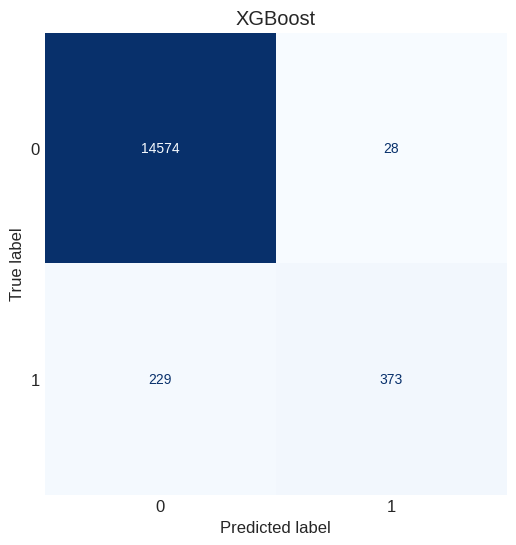

In [93]:

fig, ax = plt.subplots(figsize = (6,6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);
ax.set_title("XGBoost")
ax.grid()
plt.show()

## SMOTE

The make_classification function generates a toy dataset for a binary classification problem. It generates samples from two clusters with the given weights.

The sm = SMOTE(random_state = RANDOM_STATE) line of code creates an instance of the SMOTE (Synthetic Minority Over-sampling Technique) class, which is used to oversample the minority class in an imbalanced dataset.

The x_res, y_res = sm.fit_resample(x, y) line of code uses the SMOTE instance to oversample the minority class in the dataset. It returns a new dataset with the resampled features x_res and labels y_res.

The print('Original dataset shape shape %s' % Counter(y)) line of code prints the original distribution of the minority class in the dataset.



In [94]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
x, y = make_classification(n_classes = 2, class_sep = 2,
                           weights= [0.1, 0.9],
                           n_informative= 3, n_redundant= 1, flip_y= 0, n_features= 20,
                           n_clusters_per_class= 1, n_samples= N_SAMPLES, random_state= RANDOM_STATE)
print('Original dataset shape shape %s' % Counter(y))
sm = SMOTE(random_state = RANDOM_STATE)
x_res, y_res = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({1: 900, 0: 900})
